In [106]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from lvclassify_helpers import getdata10cat, getlvstopwords

#### Datu ielāde

In [107]:
df = getdata10cat()
df.head()

,category,body
0,Sports,Reaģējot uz Latvijas Paralimpiskās komitejas ...
1,Sports,Latvijas tenisiste Jeļena Ostapenko šodien Ķ...
2,Sports,Latvijas Sporta federāciju padome (LSFP) iebi...
3,Sports,Jaunais sporta finansējuma modelis samazinās f...
4,Sports,Aleksandrs un Mihails Samoilovi piektdien S...


#### Kategorijas vērtības uz integer

In [108]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["category"])
df['encod_cat'] = le.transform(df['category'])
# Sanity-check kategorijas datu kodējumam
print(df.head(5))
print(df.category.value_counts())
print(df.encod_cat.value_counts())

  category                                               body  encod_cat
0   Sports  Reaģējot uz  Latvijas Paralimpiskās komitejas ...          8
1   Sports  Latvijas tenisiste  Jeļena Ostapenko  šodien Ķ...          8
2   Sports  Latvijas Sporta federāciju padome  (LSFP) iebi...          8
3   Sports  Jaunais sporta finansējuma modelis samazinās f...          8
4   Sports  Aleksandrs  un  Mihails Samoilovi  piektdien S...          8
category
Sports           1200
Politika         1200
Literatūra       1200
Finanses         1200
Atpūta           1200
Kriminālziņas    1200
Kino             1200
Mūzika           1200
Auto             1200
Tehnoloģijas     1200
Name: count, dtype: int64
encod_cat
8    1200
7    1200
5    1200
2    1200
0    1200
4    1200
3    1200
6    1200
1    1200
9    1200
Name: count, dtype: int64


#### Sadalam datus 80/20

In [109]:
x_train, x_test, y_train, y_test = train_test_split(
    df['body'], df['encod_cat'], test_size=.2, stratify=df['encod_cat'], random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9600,) (2400,) (9600,) (2400,)


In [110]:
import string
punct = string.punctuation
stopwords_arr = getlvstopwords()
print(stopwords_arr)

['aiz', 'ap', 'apakš', 'apakšpus', 'ar', 'arī', 'augšpus', 'bet', 'bez', 'bija', 'biji', 'biju', 'bijām', 'bijāt', 'būs', 'būsi', 'būsiet', 'būsim', 'būt', 'būšu', 'caur', 'diemžēl', 'diezin', 'droši', 'dēļ', 'esam', 'esat', 'esi', 'esmu', 'gan', 'gar', 'iekam', 'iekams', 'iekām', 'iekāms', 'iekš', 'iekšpus', 'ik', 'ir', 'it', 'itin', 'iz', 'ja', 'jau', 'jeb', 'jebšu', 'jel', 'jo', 'jā', 'ka', 'kamēr', 'kaut', 'kolīdz', 'kopš', 'kā', 'kļuva', 'kļuvi', 'kļuvu', 'kļuvām', 'kļuvāt', 'kļūs', 'kļūsi', 'kļūsiet', 'kļūsim', 'kļūst', 'kļūstam', 'kļūstat', 'kļūsti', 'kļūstu', 'kļūt', 'kļūšu', 'labad', 'lai', 'lejpus', 'līdz', 'līdzko', 'ne', 'nebūt', 'nedz', 'nekā', 'nevis', 'nezin', 'no', 'nu', 'nē', 'otrpus', 'pa', 'par', 'pat', 'pie', 'pirms', 'pret', 'priekš', 'pār', 'pēc', 'starp', 'tad', 'tak', 'tapi', 'taps', 'tapsi', 'tapsiet', 'tapsim', 'tapt', 'tapāt', 'tapšu', 'taču', 'te', 'tiec', 'tiek', 'tiekam', 'tiekat', 'tieku', 'tik', 'tika', 'tikai', 'tiki', 'tikko', 'tiklab', 'tiklīdz', 'tik

In [111]:
def filter_stop_words(train_sentences):
    for i, sentence in enumerate(train_sentences):
        new_sent = [word for word in sentence.split() if word not in stopwords_arr]
        train_sentences.iloc[i]  = ' '.join(new_sent)
    return train_sentences
x_train = filter_stop_words(x_train)


#### Tokenizācija

In [112]:
vocab_size = 20000
token_filter = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>', filters=token_filter, lower=True)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_seq = tokenizer.texts_to_sequences(x_train)

#### Pārbaudam max sequence garumu

In [113]:
print(max([len(e) for e in x_seq]))

5861


#### Pevienojam padding, visas rindas būs ar vienādu garumu

In [114]:
padding_type = 'post'
max_len = 4500
x_train = pad_sequences(x_seq, padding=padding_type, maxlen=max_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), padding=padding_type, maxlen=max_len)

In [115]:
x_train.shape

(9600, 4500)

#### Neironu tīkla izveide ar konvolūcijas slāni

In [162]:
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size, 200, input_length=x_train.shape[1]),
                            tf.keras.layers.Conv1D(100, 5, activation='relu'),
                            tf.keras.layers.GlobalMaxPooling1D(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(df['category'].nunique(), activation='softmax')
])

In [163]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4500, 200)         4000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 4496, 100)         100100    
                                                                 
 global_max_pooling1d_6 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                1010      
                                                                 
Total params: 4101110 (15.64 MB)
Trainable params: 4101110 (15.64 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [164]:
model_save_path='./models/KNT_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)]

#### Apmācam neironu tīklu 10 etapos

In [165]:
%%time
rezultats = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2, callbacks=callbacks)

Epoch 1/10
300/300 - 113s - loss: 1.3679 - accuracy: 0.6019 - val_loss: 0.4160 - val_accuracy: 0.9108 - 113s/epoch - 377ms/step
Epoch 2/10
300/300 - 112s - loss: 0.3540 - accuracy: 0.9070 - val_loss: 0.2226 - val_accuracy: 0.9446 - 112s/epoch - 373ms/step
Epoch 3/10
300/300 - 110s - loss: 0.1741 - accuracy: 0.9563 - val_loss: 0.1756 - val_accuracy: 0.9542 - 110s/epoch - 365ms/step
Epoch 4/10
300/300 - 109s - loss: 0.0945 - accuracy: 0.9761 - val_loss: 0.1665 - val_accuracy: 0.9567 - 109s/epoch - 364ms/step
Epoch 5/10
300/300 - 110s - loss: 0.0576 - accuracy: 0.9864 - val_loss: 0.1637 - val_accuracy: 0.9571 - 110s/epoch - 366ms/step
Epoch 6/10
300/300 - 110s - loss: 0.0355 - accuracy: 0.9931 - val_loss: 0.1724 - val_accuracy: 0.9546 - 110s/epoch - 368ms/step
Epoch 7/10
300/300 - 33860s - loss: 0.0311 - accuracy: 0.9937 - val_loss: 0.1740 - val_accuracy: 0.9575 - 33860s/epoch - 113s/step
Epoch 8/10
300/300 - 110s - loss: 0.0184 - accuracy: 0.9957 - val_loss: 0.1772 - val_accuracy: 0.9554

75/75 [==============================] - 6s 80ms/step
(2400,)
(2400,)
              precision    recall  f1-score   support

           0     0.9424    0.9542    0.9482       240
           1     0.9752    0.9833    0.9793       240
           2     0.9212    0.9250    0.9231       240
           3     0.9833    0.9792    0.9812       240
           4     0.9787    0.9583    0.9684       240
           5     0.9592    0.9792    0.9691       240
           6     0.9545    0.9625    0.9585       240
           7     0.9412    0.9333    0.9372       240
           8     0.9876    0.9917    0.9896       240
           9     0.9274    0.9042    0.9156       240

    accuracy                         0.9571      2400
   macro avg     0.9571    0.9571    0.9570      2400
weighted avg     0.9571    0.9571    0.9570      2400



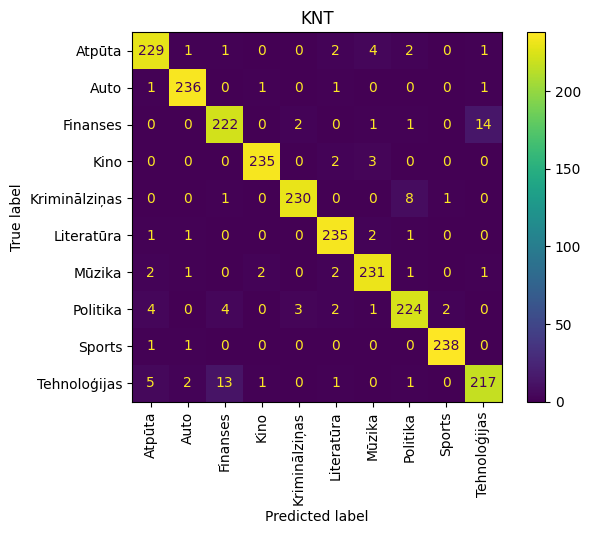

In [166]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

model_load_path='./models/KNT_model.h5'
model.load_weights(model_load_path)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_test.shape)
print(y_pred.shape)
cm = confusion_matrix(y_test, y_pred)
labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
plot = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
plot.plot(xticks_rotation=90)
plot.ax_.set_title("KNT")
print(classification_report(y_test, y_pred, digits=4))
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
accuracy_4dig = round(accuracy_score(y_test, y_pred), 4)
filenameCsv = 'Report KNT_'+ str(accuracy_4dig) + '.csv'
clsf_report.to_csv(Path(".") / 'metrics' / filenameCsv, index= True)


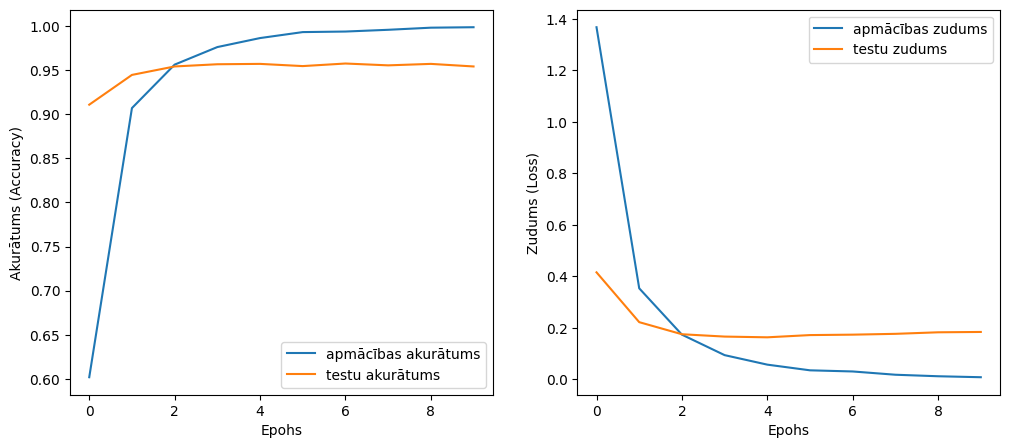

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.plot(rezultats.history['accuracy'])
plt.plot(rezultats.history['val_accuracy'])
plt.xlabel("Epohs")
plt.ylabel("Akurātums (Accuracy)")
plt.legend(['apmācības akurātums', 'testu akurātums'])
plt.subplot(122)
plt.plot(rezultats.history['loss'])
plt.plot(rezultats.history['val_loss']);
plt.xlabel("Epohs")
plt.ylabel("Zudums (Loss)")
plt.legend(['apmācības zudums', 'testu zudums']);

In [168]:
def getLabel(index):
    labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
    return labels[index]

In [169]:
def predict(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    prediction = model.predict(padded)
    predictionList = prediction.tolist()[0]
    labeled_predictions = [{getLabel(i):"%.2f%%"%(x*100)} for i, x in enumerate(predictionList)]
    return labeled_predictions

In [170]:
predict("""Pirmdien, 4. septembrī, premjera amatam nominētā Evika Siliņa (JV) sāks nākamās koalīcijas sarunas, dalot ministru amatus "Jaunās Vienotības", Zaļo un zemnieku savienības (ZZS) un partijas "Progresīvie" starpā.

Piektdien, 1. septembrī, Siliņa preses konferencē informēja, ka, "Apvienotajam sarakstam" nepiekrītot darboties nākamajā koalīcijā, tajā darbosies trīs politiskie spēki, kuriem Saeimā kopumā ir 52 balsis.

Siliņa gan neizslēdza iespēju, ka ar laiku koalīcijai varētu pievienoties vēl kāds partneris. "Vienmēr pastāv iespēja iegūt vairāk balsis, ja labi strādā," teica Siliņa.

Kā viens no potenciālajiem nākamās koalīcijas atbalstītājiem varētu būt pie frakcijām nepiederošais Oļegs Burovs, ar kuru Siliņa gan neesot runājusi, bet to darot cits nākamās koalīcijas partneris.""")

1/1 [==============================] - 0s 48ms/step


[{'Atpūta': '0.02%'},
 {'Auto': '0.01%'},
 {'Finanses': '0.05%'},
 {'Kino': '0.01%'},
 {'Kriminālziņas': '0.02%'},
 {'Literatūra': '0.02%'},
 {'Mūzika': '0.04%'},
 {'Politika': '99.77%'},
 {'Sports': '0.03%'},
 {'Tehnoloģijas': '0.03%'}]

In [171]:
predict("""Starptautiskais pašapkalpošanās un automatizācijas risinājumu ražotājs "Omnic" Liepājā būvēs jaunu rūpnīcu, lai ražotu pakomātus Eiropas tirgum, liecina uzņēmuma sniegtā informācija.

Šobrīd vēl tiek precizēta potenciāli vislabākā atrašanās vieta ražotnei, bet pirmie būvdarbi varētu tikt uzsākti jau šogad.

Darbu jaunā rūpnīca varētu sākt 2024. gadā.

Kā norāda uzņēmumā, šobrīd vēl esot grūti pateikt precīzas Liepājas rūpnīcas izmaksas, bet līdzīgā ražotnē Gruzijā "Omnic" investēja 8 miljonus eiro.

Liepājas rūpnīcā plānots ražot paku skapīšus, pašapkalpošanās kases aparātus, ar saules paneļiem aprīkotus pakomātus, paku skapīšus-ledusskapjus, kā arī dažādus citus pašapkalpošanās un automatizācijas risinājumus.""")

1/1 [==============================] - 0s 17ms/step


[{'Atpūta': '0.01%'},
 {'Auto': '0.04%'},
 {'Finanses': '2.84%'},
 {'Kino': '0.02%'},
 {'Kriminālziņas': '0.06%'},
 {'Literatūra': '0.01%'},
 {'Mūzika': '0.01%'},
 {'Politika': '0.04%'},
 {'Sports': '0.01%'},
 {'Tehnoloģijas': '96.96%'}]

In [172]:
predict("""Aizvadītajā diennaktī valstī reģistrēti 136 ceļu satiksmes negadījumi, tajos cietušas 13 personas, liecina Valsts policijas apkopotie dati.

Četri no cietušajiem bijuši gājēji, tāpat cietis viens velosipēdists un viens elektrisko skrejriteņu vadītājs.

Kopumā ceļu satiksmes jomā pieņemti 456 administratīvo pārkāpumu lēmumi, tajā skaitā 195 par ātruma pārsniegšanu un viens par agresīvu braukšanu.""")

1/1 [==============================] - 0s 15ms/step


[{'Atpūta': '0.12%'},
 {'Auto': '0.01%'},
 {'Finanses': '0.12%'},
 {'Kino': '0.01%'},
 {'Kriminālziņas': '99.41%'},
 {'Literatūra': '0.00%'},
 {'Mūzika': '0.00%'},
 {'Politika': '0.10%'},
 {'Sports': '0.00%'},
 {'Tehnoloģijas': '0.23%'}]

In [173]:
predict("""Serbijas tenisists Novaks Džokovičs piektdien ASV atklātā čempionāta trešās kārtas spēlē pret savu tautieti Laslo Džeri zaudēja pirmajos divos setos, tomēr atspēlējās un svinēja uzvaru.

Ranga vicelīderis Džokovičs ATP 38.numuru Džeri vairāk nekā trīsarpus stundu cīņā uzvarēja ar rezultātu 4-6, 4-6, 6-1, 6-1, 6-3.

Kopš 2007.gada Džokovičs visos "US Open" turnīros, kuros piedalījies, ticis tālāk par trešo kārtu, 2011., 2015. un 2018.gadā kļūstot par čempionu.

"Esmu parādījis, ka varu aizvadīt arī piecu setu mačus. Atspēlēšanās pēc diviem zaudētiem setiem rāda skaidru signālu maniem nākamajiem pretiniekiem, taču nav tā, ka vēlējos nonākt šādā situācijā. Labprāt uzvarētu trīs setos," pēc uzvaras teica Džokovičs.""")

1/1 [==============================] - 0s 15ms/step


[{'Atpūta': '0.01%'},
 {'Auto': '1.68%'},
 {'Finanses': '0.02%'},
 {'Kino': '0.05%'},
 {'Kriminālziņas': '0.00%'},
 {'Literatūra': '0.01%'},
 {'Mūzika': '0.01%'},
 {'Politika': '0.02%'},
 {'Sports': '98.19%'},
 {'Tehnoloģijas': '0.01%'}]

In [174]:
predict("""Populārā latviešu dziedātāja Samanta Tīna Poļakova "Instagram" vietnē pavēstījusi, ka teikusi jāvārdu savam draugam. Viņas pirkstā iemirdzējies gredzentiņš ar akmeni sirds formā.

34 gadus vecā dziedātāja vēsta: "Jā!" un, apskāvusi savu mīļoto, ziņo, ka saderināšanās notikusi 30. augustā. Vairāki desmiti tūkstoši Samantas sekotāji priecīgo ziņu novērtējuši atzinīgi.

Samanta Tīna līdz šim nav atklājusi, kā sauc viņas mīļoto vīrieti jau labu laiku māksliniece izvēlējusies savu privāto dzīvi neafišēt.

Pirms trim gadiem dziedātāja šķīrās no sava ilgaddējā drauga Naura Liepiņa. Šajā pavasarī TV raidījumā "Kad viņas satiekas" Samanta atklāja, ka vairs nav brīvas meitenes statusā ar mīļoto iepazinusies 2022. gada rudenī pirms sev nozīmīgā ceļojuma uz Indiju. Puiša vārdu neatklājot, māksliniece vēstīja, ka abi iepazinušies attālināti un pēc ilgākas sarakstes pirmo reizi satikušies Samantas koncertā.""")

1/1 [==============================] - 0s 15ms/step


[{'Atpūta': '20.84%'},
 {'Auto': '2.08%'},
 {'Finanses': '0.51%'},
 {'Kino': '3.42%'},
 {'Kriminālziņas': '0.88%'},
 {'Literatūra': '1.47%'},
 {'Mūzika': '65.41%'},
 {'Politika': '2.56%'},
 {'Sports': '2.33%'},
 {'Tehnoloģijas': '0.50%'}]